# Exemplo com dados da Johnson & Johnson #

In [7]:
import numpy as np

import pandas as pd
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

from matplotlib import pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

from statsmodels.graphics.tsaplots import plot_predict
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf

import warnings
warnings.filterwarnings('ignore')

In [8]:
data = pd.read_csv('jj.csv')
data.head()

,date,data
0,1960-01-01,0.71
1,1960-04-01,0.63
2,1960-07-02,0.85
3,1960-10-01,0.44
4,1961-01-01,0.61


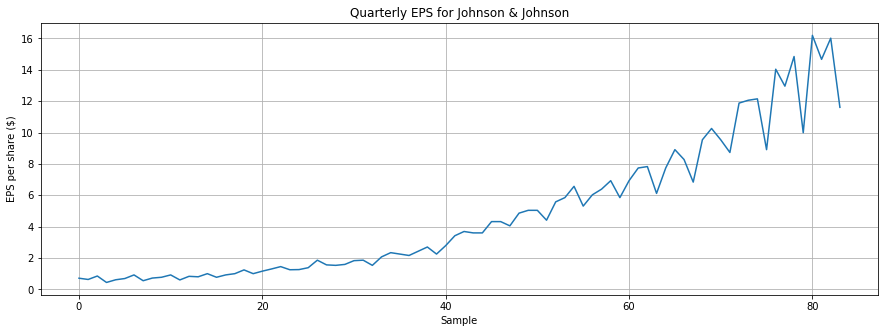

([<matplotlib.lines.Line2D at 0x1a1e033470>], None, None)

In [12]:
plt.figure(figsize=(15,5))
plt.xlabel('Sample')
plt.title('Quarterly EPS for Johnson & Johnson')
plt.ylabel('EPS per share ($)')
plt.plot(data['data']), plt.grid(), plt.show()

In [26]:
def get_stationarity(timeseries,window=4*2):
    
    # rolling statistics
    rolling_mean = timeseries.rolling(window=window).mean()
    rolling_std = timeseries.rolling(window=window).std()
    
    # rolling statistics plot
    original = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(rolling_mean, color='red', label='Rolling Mean')
    std = plt.plot(rolling_std, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    # Dickey–Fuller test:
    result = adfuller(timeseries)
    print('ADF Statistic: {}'.format(result[0]))
    print('p-value: {}'.format(result[1]))
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t{}: {}'.format(key, value))

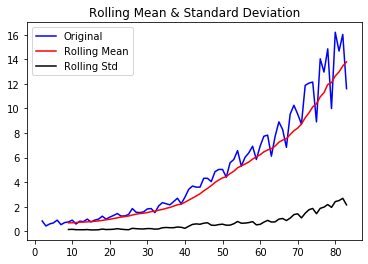

ADF Statistic: 2.736278006540935
p-value: 0.9990880700973198
Critical Values:
	1%: -3.5274258688046647
	5%: -2.903810816326531
	10%: -2.5893204081632653


In [27]:
# Augmented Dickey-Fuller test
get_stationarity(data['data'])

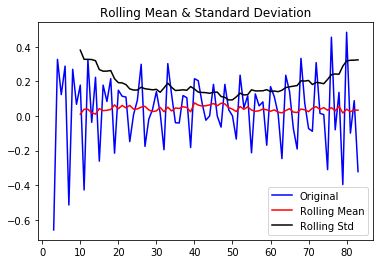

ADF Statistic: -3.131561026266191
p-value: 0.024303996976237977
Critical Values:
	1%: -3.5232835753964475
	5%: -2.902030597326081
	10%: -2.5883710883843123


In [28]:
# Take the log difference to make data stationary

data['dte'] = np.log(data['data']).diff()
data = data.drop(data.index[0])
data.head()

# Augmented Dickey-Fuller test
get_stationarity(data['dte'])

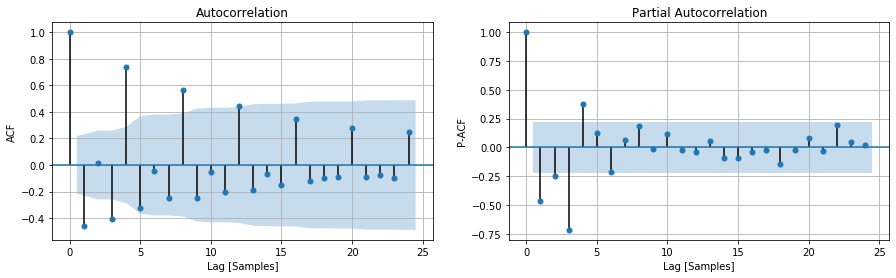

In [29]:
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=[15, 4])
plot_acf(data['dte'],lags=24,ax=ax1)
ax1.set_ylabel('ACF'), ax1.set_xlabel('Lag [Samples]')
ax1.grid(True)
plot_pacf(data['dte'],lags=24,ax=ax2)
ax2.set_ylabel('P-ACF'), ax2.set_xlabel('Lag [Samples]')
ax2.grid(True)
plt.show()

In [33]:
data['dte'] = np.log(data['data'])
data.head()

,date,data,dte
3,1960-10-01,0.44,-0.820981
4,1961-01-01,0.61,-0.494296
5,1961-04-02,0.69,-0.371064
6,1961-07-02,0.92,-0.083382
7,1961-10-01,0.55,-0.597837


In [37]:
model = ARIMA(data['dte'], order=(4,1,2),trend="t")
res = model.fit()
print(res.summary())

                               SARIMAX Results                                
Dep. Variable:                    dte   No. Observations:                   81
Model:                 ARIMA(4, 1, 2)   Log Likelihood                  82.537
Date:                Tue, 04 May 2021   AIC                           -149.074
Time:                        12:02:57   BIC                           -130.017
Sample:                             0   HQIC                          -141.433
                                 - 81                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0405      0.004      9.757      0.000       0.032       0.049
ar.L1         -0.9162      0.445     -2.058      0.040      -1.789      -0.044
ar.L2         -0.8589      0.452     -1.901      0.0

In [38]:
def eval_model(dt,res):
    plt.plot(dt)
    plt.plot(res.fittedvalues[1:], color='red')
    plt.title('Fitted Values')
    plt.xlabel('Sample')
    plt.ylabel('Time series')

    # Resíduos do modelo estimado
    resid = res.resid


    fig, (ax1,ax2) = plt.subplots(1, 2, figsize=[15, 4])
    plot_acf(resid,lags=24,ax=ax1)
    ax1.set_ylabel('ACF'), ax1.set_xlabel('Lag [Samples]')
    ax1.grid(True)
    plot_pacf(resid,lags=24,ax=ax2)
    ax2.set_ylabel('P-ACF'), ax2.set_xlabel('Lag [Samples]')
    ax2.grid(True)
    plt.show()

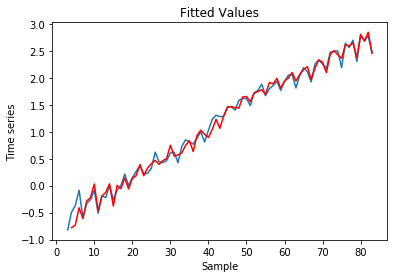

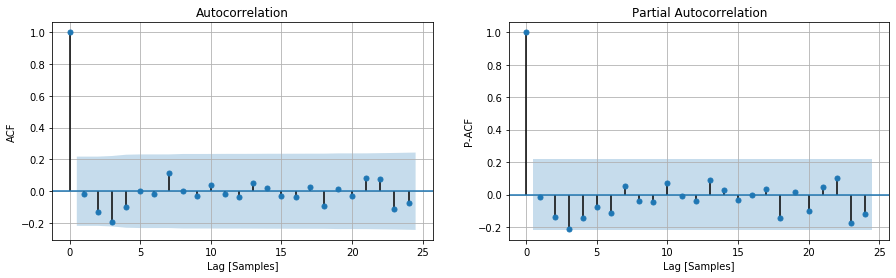

In [39]:
eval_model(data['dte'],res)

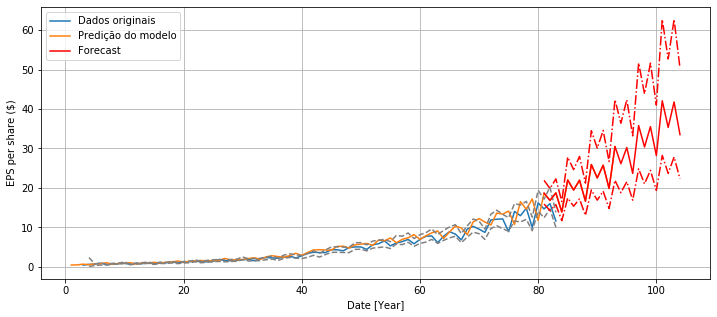

(None, <matplotlib.legend.Legend at 0x1a1f508d68>, None)

In [43]:
fig, ax = plt.subplots(figsize=(12,5))

# Original data
plt.plot(data['data'],label='Dados originais')

# Model prediction
px = res.predict(start=1, end=len(data['dte'])+12)
plt.plot(np.exp(px), label='Predição do modelo')
# Prediction confidence interval
predict_dy = res.get_prediction()
predict_dy_ci = predict_dy.conf_int()
ax.plot(np.exp(predict_dy_ci[1:]),'--',color='gray')


# Forecast - 3 years
fore = res.get_forecast(steps=12)
forecast_ci = fore.conf_int()
plt.plot(np.exp(forecast_ci),'-.',color='red')
forecasts = np.exp(res.forecast(steps=12))
forecasts.plot(color='red',label='Forecast')

plt.xlabel('Date [Year]')
plt.ylabel('EPS per share ($)')
plt.grid(True), plt.legend(), plt.show()